<a href="https://colab.research.google.com/github/edquestofficial/Gen-AI-Cohort/blob/main/2024/april/Level_2/2_day/2_simple_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up the necessary libraries

In [ ]:
!pip install PyPDF2 #nltk
!pip install sentence-transformers
!pip install chromadb

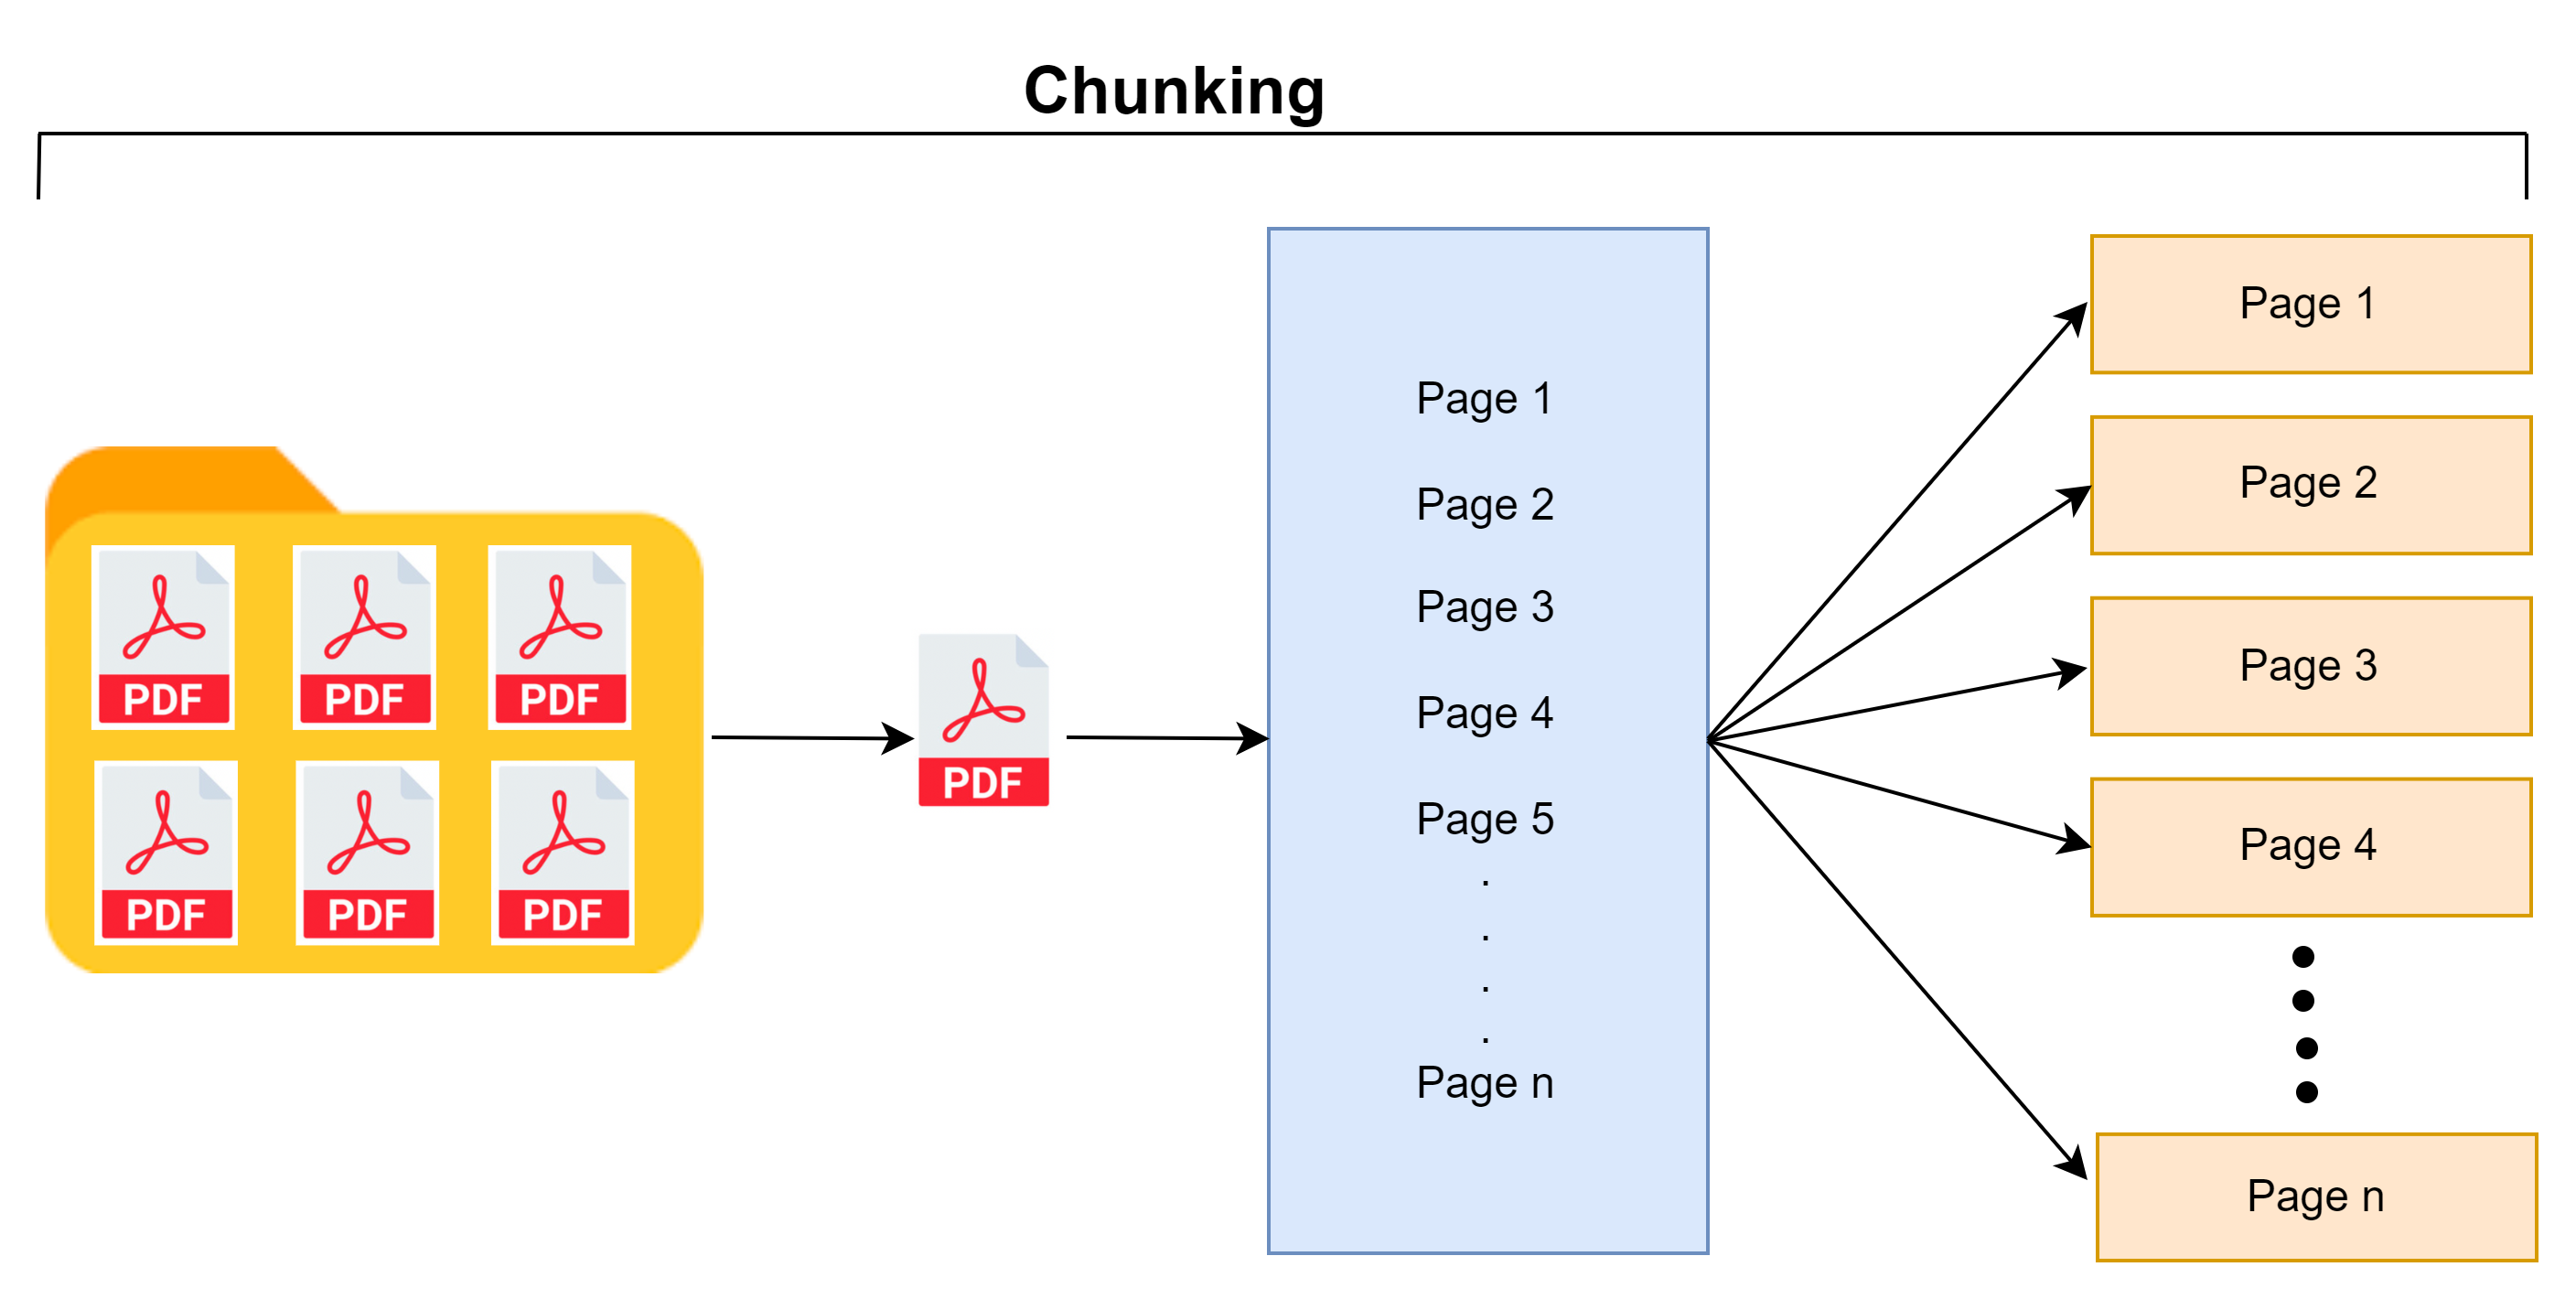

In [3]:
import re
import ast
import PyPDF2
import numpy as np
import pandas as pd
from google.colab import drive
from sentence_transformers import SentenceTransformer, util

## Connect Google Drive to access the PDF knowledge base

In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Chunking Strategies
  - Fix size chunking
  - Sentense or paragraph based chunking
  - Page-based Chunking

### Fix size chunking

In [5]:
def fix_size_text_chunker(text, chunk_size):
    """
    Splits text into chunks based on the specified chunk size.

    Args:
        text (str): The input text to be chunked.
        chunk_size (int): The maximum size of each chunk.

    Returns:
        list: A list of text chunks.
    """
    chunks = []  # List to store the text chunks
    words = text.split()  # Split the text into words

    current_chunk = []  # Store words for the current chunk
    current_chunk_length = 0  # Total length of words in the current chunk

    # Iterate through each word in the text
    for word in words:
        # Check if adding the current word to the chunk exceeds the chunk size
        if current_chunk_length + len(word) + 1 <= chunk_size:
            current_chunk.append(word)
            current_chunk_length += len(word) + 1
        else:
            # Add the current chunk to the list of chunks
            chunks.append(' '.join(current_chunk))
            # Start a new chunk with the current word
            current_chunk = [word]
            current_chunk_length = len(word)

    # Append the remaining chunk if it's not empty
    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

### Sentense or paragraph based chunking

In [6]:
def sentence_chunker(text, pdf_meta):
    """
    Extracts and chunks sentences from a PDF page.

    Args:
        pdf_page (str): The text extracted from the PDF page.
        pdf_meta (str): Metadata of the PDF.

    Returns:
        data: A dictionary containing page title and chunked text.
    """

    # Split the text into sentences
    # sentence_chunks = extract_sentences_from_text(text)
    sentence_chunks = text.split('\n')  # Split the text into lines to extract sentences

    # Create a dictionary to store the chunks and page title
    data = {'Title': [], 'Chunk Text': []}

    # Add page title and chunked text to the dictionary
    for idx, chunk in enumerate(sentence_chunks):
        data['Title'].append(pdf_meta["/Creator"])
        data['Chunk Text'].append(chunk)

    return data

### Page-based Chunking

In [7]:
def page_chunker(text, pdf_meta):
    """
    Extracts and chunks text from a PDF page.

    Args:
        text: The PDF page extracted text.
        pdf_meta: Metadata of the PDF.

    Returns:
        data: A dictionary containing page title and chunked text.
    """
    # Create a dictionary to store the chunks and page title
    data = {'Title': [], 'Chunk Text': []}

    # Add page title and chunked text to the dictionary
    data['Title'].append(pdf_meta["/Creator"])
    data['Chunk Text'].append(text)

    return data

## Apply the specified chunking strategies

In [76]:
# Open the PDF file
pdf_file = open('/content/drive/MyDrive/Gen Ai/upgrad/data/policy.pdf', 'rb')

# Create lists to store chunked data
fix_all_dfs = []
sentence_all_dfs = []
page_all_dfs = []

# Chunk size for fixed-size text chunking
chunk_size = 500

# Create a PDF reader object
pdf_reader = PyPDF2.PdfReader(pdf_file)

# Number of pages in the PDF
pdf_pages_count = len(pdf_reader.pages)
pdf_meta = pdf_reader.metadata
print(f"Number of pages in pdf {pdf_pages_count}")
print(f"Metadata about pdf {pdf_meta}")


# Iterate through each page in the PDF
for page_num in range(pdf_pages_count):
  # Extract the text from the current page
  text = pdf_reader.pages[page_num].extract_text()
  text = re.sub(r'^\s*$\n', '', text, flags=re.MULTILINE)  # Remove blank lines
  text = re.sub(r'\|?\s*\|\s*\|?', '', text)  # Remove table lines
  # page = pdf_reader.pages[page_num]

  # Fix size chunk
  fix_chunk_data = fix_size_text_chunker(text, chunk_size)

  #
  sentence_chunkdata = sentence_chunker(text, pdf_meta)

  #
  page_chunk_data = page_chunker(text, pdf_meta)

  # Append chunked data to respective lists
  fix_all_dfs.append(pd.DataFrame({'chunk' : fix_chunk_data}))
  # sentence_all_dfs.append(pd.DataFrame({'chunk' : sentence_chunkdata}))
  # page_all_dfs.append(pd.DataFrame({'chunk' : page_chunk_data}))

# Concatenate all DataFrames
fix_chunk_df = pd.concat(fix_all_dfs, ignore_index=True)
# sentence_chunk_df = pd.concat(sentence_all_dfs, ignore_index=True)
# page_chunk_df = pd.concat(page_all_dfs, ignore_index=True)

# Close the PDF file
pdf_file.close()
print(f"fix_chunk_df.shape : {fix_chunk_df.shape}")
# print(f"sentence_chunk_df : {sentence_chunk_df.shape}")
# print(f"page_chunk_df.shape : {page_chunk_df.shape}")

Number of pages in pdf 33
Metadata about pdf {'/CreationDate': 'D:20240408101550', '/Creator': 'PDFium', '/Producer': 'PDFium'}
fix_chunk_df.shape : (178, 1)


In [77]:
print("===================")
print(fix_chunk_df.head(2))

                                               chunk
0  Part A <<Date>> <<Policyholder’s Name>> <<Poli...
1  contract between HDFC Life Insurance Company L...


In [65]:
print("=======================")
print(sentence_chunk_df.head(2))

                                               chunk
0  [             Part A , <<Date>> , <<Policyhold...
1  [PDFium, PDFium, PDFium, PDFium, PDFium, PDFiu...


In [66]:
print("===================")
print(page_chunk_df.head(2))

                                               chunk
0  [             Part A \n<<Date>> \n<<Policyhold...
1                                           [PDFium]


## Embedding

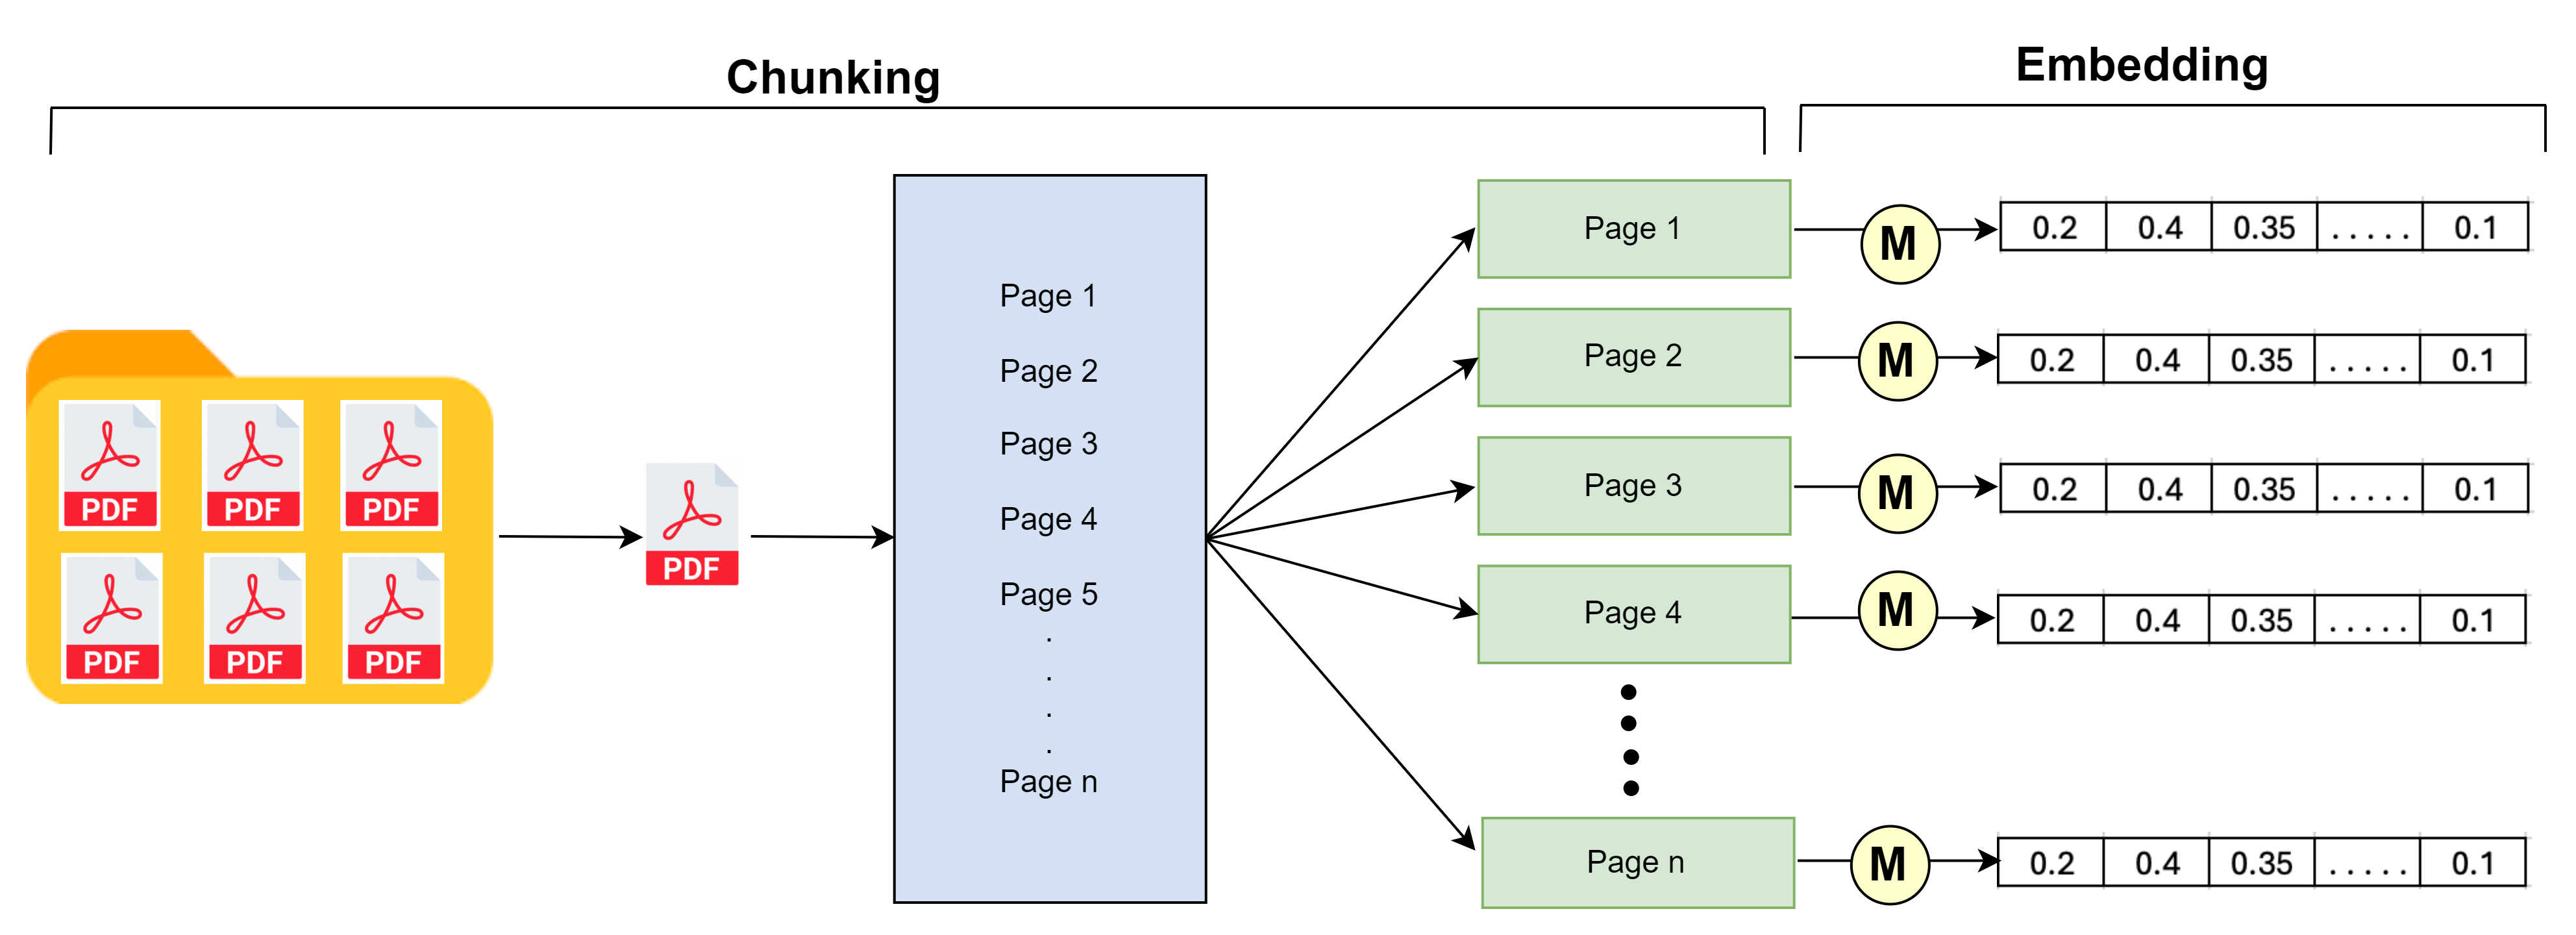

In [78]:
# Load pre-trained Sentence Transformer model
# !pip install sentence-transformers ## Library which we are using to use pre-train model
# from sentence_transformers import SentenceTransformer, util ## import statement

model_name = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

In [79]:
# Function to generate embeddings for text
def generate_embeddings_from_model(texts):
    # embeddings = embedder.encode(texts, convert_to_tensor=True)
    embeddings = embedder.encode(texts)
    return embeddings

In [80]:
def generate_df_embeddings(df):
  df['Embeddings'] = df['chunk'].apply(lambda x: generate_embeddings_from_model([x])[0])

In [83]:
fix_chunk_df.shape

(178, 1)

In [82]:
## we can use any data frame which we generated from chunking
df = fix_chunk_df.copy(deep=True)
# df = page_chunk_df
# df = sentence_chunk_df
print(df.shape)
generate_df_embeddings(df)
print(df.shape)

(178, 1)
(178, 2)


In [30]:
df.head()

,0,Embeddings
0,Part A <<Date>> <<Policyholder’s Name>> <<Poli...,"[-0.048542503, 0.083421804, 0.023615824, -0.00..."
1,contract between HDFC Life Insurance Company L...,"[-0.013738917, 0.07530584, 0.012170241, -0.024..."
2,"stating the reasons thereof, within 30 days fr...","[-0.05583609, 0.07755108, 0.076890595, -0.0094..."
3,and stamp duty charges. / In case you are not ...,"[-0.062220056, 0.058102705, 0.08673157, 0.0365..."
4,Premium for the period of cover and the expens...,"[-0.0742531, 0.05499281, 0.036231767, -0.00304..."


In [17]:
# df['Embeddings'] = df['Embeddings'].apply(lambda x: np.array2string(x, separator=', '))

In [31]:
type(df['Embeddings'][0])
# test = df['Embeddings'][0][1:5]
# arr_str = np.array2string(test, separator=', ')
# print(arr_str)

numpy.ndarray

In [84]:
len(df['Embeddings'][0])
# what it means exactly of this length & embeddings

384

In [85]:
df.head()

,chunk,Embeddings
0,Part A <<Date>> <<Policyholder’s Name>> <<Poli...,"[-0.048542503, 0.083421804, 0.023615824, -0.00..."
1,contract between HDFC Life Insurance Company L...,"[-0.013738917, 0.07530584, 0.012170241, -0.024..."
2,"stating the reasons thereof, within 30 days fr...","[-0.05583609, 0.07755108, 0.076890595, -0.0094..."
3,and stamp duty charges. / In case you are not ...,"[-0.062220056, 0.058102705, 0.08673157, 0.0365..."
4,Premium for the period of cover and the expens...,"[-0.0742531, 0.05499281, 0.036231767, -0.00304..."


In [86]:
# Save the embeddings in a CSV
output_path = './'

# Save the dataframe with embeddings
df.to_csv(output_path+"embeddings.csv", index=False)

## Semantic Search

In [87]:
# Read user input query
user_query = input()

what all are the benefits of this policy


In [89]:
# Define the function for calculating cosine similarity

def calculate_similarity(embedding1, embedding2):
    cosine_score = util.pytorch_cos_sim(embedding1, embedding2)
    # Convert the result to a Python float
    similarity = cosine_score.item()

    return similarity

In [90]:
# Function to perform semantic search and return ranked chunks
def semantic_search(user_query, df, embedder):

    # Calculate the query embedding
    # query_embedding = embedder.encode(user_query, convert_to_tensor=True)
    query_embedding = embedder.encode(user_query)
    print(f"query_embedding type : {type(query_embedding)}")

    # Calculate similarity scores between the query embedding and all chunk embeddings
    df['Similarity'] = df['Embeddings'].apply(lambda x: calculate_similarity(query_embedding, x))

    # Sort the DataFrame by similarity scores in descending order
    df = df.sort_values(by='Similarity', ascending=False).reset_index(drop=True)

    # Return only the top 3 values from the dataframe, and drop the embeddings column for a cleaner view of the final results
    df = df.head(5)
    df.drop('Embeddings', axis = 1, inplace=True)

    return df

In [91]:
# Perform semantic search on each DataFrame
df_results = semantic_search(user_query, df, embedder)

query_embedding type : <class 'numpy.ndarray'>


In [92]:
df_results.head()

,chunk,Similarity
0,remedies including those under the Insurance A...,0.502310
1,Benefit; 4. Non-fulfilment of eligibility crit...,0.457203
2,Plan option Benefits covered A DHCB B SB C CIB...,0.450901
3,"Illness Benefit, the benefit shall terminate f...",0.446336
4,Insured is the face value of the Policy contra...,0.430828


# add page number in results

In [42]:
df_results.shape

(5, 2)

In [ ]:
# !pip install plotly umap-learn

In [ ]:
# import plotly.express as px
# import umap

# Vector Databases & Retrieval Augmented Generation

In this session, you will learn about vector databases such as ChromaDB and augment the capabilities of a semantic search application with vector database.


In [43]:
# Import required libraries

# import numpy as np
# import pandas as pd
# import ast

In [93]:
section_chunk_embeddings = pd.read_csv('embeddings.csv')

In [94]:
section_chunk_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   chunk       178 non-null    object
 1   Embeddings  178 non-null    object
dtypes: object(2)
memory usage: 2.9+ KB


In [95]:
section_chunk_embeddings.head()

,chunk,Embeddings
0,Part A <<Date>> <<Policyholder’s Name>> <<Poli...,[-4.85425033e-02 8.34218040e-02 2.36158241e-...
1,contract between HDFC Life Insurance Company L...,[-1.37389172e-02 7.53058419e-02 1.21702412e-...
2,"stating the reasons thereof, within 30 days fr...",[-5.58360890e-02 7.75510818e-02 7.68905953e-...
3,and stamp duty charges. / In case you are not ...,[-6.22200556e-02 5.81027046e-02 8.67315680e-...
4,Premium for the period of cover and the expens...,[-7.42530972e-02 5.49928099e-02 3.62317674e-...


### Data preprocessing

In [ ]:
# If convert_to_tensor=True then need to execute this cell else ignore it
section_chunk_embeddings['Embeddings'] = section_chunk_embeddings['Embeddings'].apply(lambda x: x[7:][:-15])

In [47]:
df['Embeddings'] = df['Embeddings'].apply(lambda x: np.array2string(x, separator=', '))

In [48]:
section_chunk_embeddings['Embeddings'][0]

'[-4.85425033e-02  8.34218040e-02  2.36158241e-02 -7.79010262e-03\n  9.27361175e-02  9.55910981e-02  5.99303134e-02  6.58518374e-02\n -1.06581174e-01  3.38603407e-02  2.71677617e-02 -2.19194740e-02\n -1.59931183e-02 -4.11735475e-02 -3.33174616e-02 -1.88978612e-02\n -5.37875015e-03 -8.10570270e-02 -1.92050226e-02  9.12455246e-02\n -1.72288064e-02  6.17922097e-02  2.99981292e-02  1.87889710e-02\n -3.45928073e-02  2.86893453e-02 -2.38301512e-03  4.41165045e-02\n -5.80592640e-03  2.72558592e-02  7.13607669e-02  2.71159969e-02\n  4.51951735e-02 -5.84262796e-02  5.58830462e-02  1.78832877e-02\n -8.86616930e-02 -4.06476781e-02 -8.66793841e-02 -1.33354990e-02\n -2.08506286e-02 -9.46401879e-02 -5.27647976e-03  2.62769405e-02\n  5.66774346e-02 -1.38988802e-02 -1.46098714e-03  4.18992192e-02\n  3.71052250e-02  6.44057691e-02 -5.10115996e-02 -5.09970933e-02\n  2.86112335e-02 -3.38380970e-02  5.66885620e-02  2.72047184e-02\n  9.13088117e-03 -6.09120056e-02 -4.35403846e-02 -7.96616171e-03\n -3.46581

In [36]:
section_chunk_embeddings['Embeddings'] = section_chunk_embeddings['Embeddings'].apply(lambda x: ast.literal_eval(x))

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

In [ ]:
section_chunk_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Title       44 non-null     object
 1   Chunk Text  44 non-null     object
 2   Embeddings  44 non-null     object
dtypes: object(3)
memory usage: 1.2+ KB


In [56]:
section_chunk_embeddings

,0,Embeddings,Similarity
0,Part A <<Date>> <<Policyholder’s Name>> <<Poli...,"[-4.85425033e-02, 8.34218040e-02, 2.36158241...",0.424405
1,contract between HDFC Life Insurance Company L...,"[-1.37389172e-02, 7.53058419e-02, 1.21702412...",0.327490
2,"stating the reasons thereof, within 30 days fr...","[-5.58360890e-02, 7.75510818e-02, 7.68905953...",0.339195
3,and stamp duty charges. / In case you are not ...,"[-6.22200556e-02, 5.81027046e-02, 8.67315680...",0.290385
4,Premium for the period of cover and the expens...,"[-7.42530972e-02, 5.49928099e-02, 3.62317674...",0.293300
...,...,...,...
173,assignment or transfer is delivered to the ins...,"[-4.43194769e-02, 3.18349674e-02, -1.01668881...",0.167497
174,conditions of transfer or assignment OR b. whe...,"[-4.69484031e-02, 3.46937925e-02, -2.55598370...",0.262625
175,contrary to the above position. (14) In other ...,"[-5.70014715e-02, 1.14059992e-01, -2.99862567...",0.200769
176,obtaining the consent of the transferor or ass...,"[-4.98078912e-02, 1.23651013e-01, -3.07653584...",0.300193


In [57]:
section_chunk_embeddings['Embeddings'][0]

'[-4.85425033e-02,  8.34218040e-02,  2.36158241e-02, -7.79010262e-03,\n  9.27361175e-02,  9.55910981e-02,  5.99303134e-02,  6.58518374e-02,\n -1.06581174e-01,  3.38603407e-02,  2.71677617e-02, -2.19194740e-02,\n -1.59931183e-02, -4.11735475e-02, -3.33174616e-02, -1.88978612e-02,\n -5.37875015e-03, -8.10570270e-02, -1.92050226e-02,  9.12455246e-02,\n -1.72288064e-02,  6.17922097e-02,  2.99981292e-02,  1.87889710e-02,\n -3.45928073e-02,  2.86893453e-02, -2.38301512e-03,  4.41165045e-02,\n -5.80592640e-03,  2.72558592e-02,  7.13607669e-02,  2.71159969e-02,\n  4.51951735e-02, -5.84262796e-02,  5.58830462e-02,  1.78832877e-02,\n -8.86616930e-02, -4.06476781e-02, -8.66793841e-02, -1.33354990e-02,\n -2.08506286e-02, -9.46401879e-02, -5.27647976e-03,  2.62769405e-02,\n  5.66774346e-02, -1.38988802e-02, -1.46098714e-03,  4.18992192e-02,\n  3.71052250e-02,  6.44057691e-02, -5.10115996e-02, -5.09970933e-02,\n  2.86112335e-02, -3.38380970e-02,  5.66885620e-02,  2.72047184e-02,\n  9.13088117e-03, -

In [61]:
print(f"type : {type(section_chunk_embeddings['Embeddings'][0])}")
section_chunk_embeddings.head(2)

type : <class 'str'>


,0,Embeddings,Similarity
0,Part A <<Date>> <<Policyholder’s Name>> <<Poli...,"[-4.85425033e-02, 8.34218040e-02, 2.36158241...",0.424405
1,contract between HDFC Life Insurance Company L...,"[-1.37389172e-02, 7.53058419e-02, 1.21702412...",0.327490


## 2. <font color = red> ChromaDB </font>

### <font color = red> 2.1 Adding documents/embeddings to ChromaDB and working with Collections </font>

You can add embeddings or chunks of text directly to chroma using their collection methods.

* **`.create_collection()`**
* **`.list_collections()`**
* **`.delete_collections()`**

In [98]:
print(type(section_chunk_embeddings['chunk']))
print(type(section_chunk_embeddings['Embeddings']))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [100]:
from chromadb.config import Settings
import chromadb

# Create a Chroma client
client = chromadb.Client(Settings(
    persist_directory="./"
))

# Create a collection to store the embeddings and chunks
collection = client.create_collection(name="policy_knowledge_base1")

# Add the embeddings and chunks to the collection
collection.add(
    documents=section_chunk_embeddings['chunk'].tolist(),
    embeddings=section_chunk_embeddings['Embeddings'].tolist(),
)

TypeError: Collection.add() missing 1 required positional argument: 'ids'

In [ ]:
# prompt: read a pdf and create its chunks and then store these chunks in pandas dataframe

import PyPDF2
import pandas as pd

# Open the PDF file
pdf_file = open('example.pdf', 'rb')

# Read the PDF file
pdf_reader = PyPDF2.PdfFileReader(pdf_file)

# Initialize an empty list to store the chunks
chunks = []

# Loop over the pages in the PDF file
for page_num in range(pdf_reader.numPages):
    page = pdf_reader.getPage(page_num)

    # Extract the text from the page
    text = page.extractText()

    # Split the text into chunks
    for chunk in text.split('\n'):
        chunks.append(chunk)

# Create a Pandas DataFrame from the list of chunks
df = pd.DataFrame(chunks, columns=['chunk'])

# Print the DataFrame
print(df)

# Close the PDF file
pdf_file.close()


In [ ]:
# Perform a vector similarity search
results = collection.query(
    query_texts=["What is the capital of France?"],
    n_results=5,
)

# Print the retrieved chunks
for result in results:
    print(result.text)

In [59]:
# Import ChromaDB and get the Chroma client

import chromadb
# chroma_client = chromadb.PersistentClient(path="./")
chroma_client = chromadb.PersistentClient()

In [60]:
# Create a collection to store the embeddings. Collections in Chroma are where you can store your embeddings, documents, and any additional metadata.

collection = chroma_client.get_or_create_collection(name="Semantic_Search_with_Chromadb")

In [62]:
# Add the documents, embeddings, and ids into the collection

collection.add(
    embeddings = section_chunk_embeddings['Embeddings'].to_list(),
    # documents = section_chunk_embeddings['Chunk Text'].to_list(),
    documents = section_chunk_embeddings[0].to_list(),
    ids = [str(i) for i in range(0, len(section_chunk_embeddings['Embeddings']))],
)

KeyError: 0

In [ ]:
# Peek at the initial elements of the collection

collection.peek()

{'ids': ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17'],
 'embeddings': [[-0.066989,
   0.074974,
   0.032001,
   -0.037859,
   -0.018461,
   0.018331,
   0.038427,
   -0.04774,
   -0.099445,
   -0.0093504,
   0.011001,
   -0.00027183,
   0.023394,
   -0.051176,
   -0.068009,
   -0.047251,
   0.019483,
   -0.083557,
   -0.03674,
   0.059763,
   0.055849,
   0.038453,
   -0.035451,
   0.048398,
   0.0054165,
   0.027465,
   0.075562,
   0.12596,
   -0.026926,
   -0.055114,
   -0.0089227,
   -0.023662,
   0.0047804,
   -0.062813,
   0.024441,
   -0.021491,
   -0.11114,
   -0.026511,
   -0.036382,
   -0.03215,
   0.017197,
   -0.081348,
   -0.040799,
   0.064908,
   0.043971,
   0.116,
   -0.0010844,
   -0.022452,
   0.059822,
   0.053548,
   -0.017188,
   -0.0061356,
   0.084377,
   -0.11015,
   0.016937,
   -0.077073,
   -0.084847,
   0.070767,
   -0.0052444,
   -0.021232,
   0.015058,
   -0.029389,
   -0.033826,
   0.0034559,
   0.062975,
   0.04384,
   -0.0051494,
   -0.020

In [ ]:
# Retrieve items from the collection

collection.get(
    ids = ['0','1']
)

{'ids': ['0', '1'],
 'embeddings': None,
 'metadatas': [None, None],
 'documents': ['Vehicle Details Policy Details Make ROYAL ENFIELD Policy No. 2301 2045 6118 6201 000 Model - Variant CLASSIC-Classic 350 Period of InsuranceFrom 15 Mar, 2024 00:01 hrs Registration No HR-26-DD-2318 To 14 Mar, 2025 Midnight Engine No. U3S5C1HB480706 Issuance Date 12/03/2024 Chassis No.',
  'ME3U3S5C1HC817838 Invoice No. 204561186201000 Cubic Capacity/Watts 346 Seats 2 Customer Id 100491768765 Year of Manufacture 2017 Body Type OPEN PAN No. AUGPR4819N RTO GURGAON EIA No. Not provided Payment Details : 1222403094695 , Bank Name:Bizdirect Email ID : rmxxxxxxx91@gxxxx.com MR RAMAN RAMAN .'],
 'uris': None,
 'data': None}

In [ ]:
# List all the collection created

chroma_client.list_collections()

[Collection(name=Semantic_Search_with_Chromadb)]

In [ ]:
# Delete a collection

# chroma_client.delete_collection("Temporary")

### <font color = red> 2.2 Querying on ChromaDB </font>

* **`collection.query()`**

In [ ]:
# Read the query from the user
query = input()

# Query the ChromaDB collection using `collection.query()
results = collection.query(
    query_texts=query,
    n_results=3,
    include = ['documents', 'distances']
)

email id ?


/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:02<00:00, 29.7MiB/s]


In [ ]:
# Encode query using Sentence Transformer model

# model_name = "all-MiniLM-L6-v2"
# embedder = SentenceTransformer(model_name)
# query_embedding = embedder.encode(query)

In [ ]:
# See the results

results

{'ids': [['1', '19', '22']],
 'distances': [[1.42174956933213, 1.44759227519755, 1.4862446965419427]],
 'metadatas': None,
 'embeddings': None,
 'documents': [['ME3U3S5C1HC817838 Invoice No. 204561186201000 Cubic Capacity/Watts 346 Seats 2 Customer Id 100491768765 Year of Manufacture 2017 Body Type OPEN PAN No. AUGPR4819N RTO GURGAON EIA No. Not provided Payment Details : 1222403094695 , Bank Name:Bizdirect Email ID : rmxxxxxxx91@gxxxx.com MR RAMAN RAMAN .',
   '2301204561186201000Certificate of Insurance cum Policy Schedule Motor Insurance - Two Wheeler Comprehensive Policy 2301204561186201000 HDFC ERGO General Insurance Company Limited. IRDAI Reg No.146 CIN : U66030MH2007PLC177117. Registered & Corporate Office: 1st Floor, HDFC House, 165/166 Backbay',
   'ME3U3S5C1HC817838 Invoice No. 204561186201000 Cubic Capacity/Watts 346 Seats 2 Customer Id 100491768765 Year of Manufacture 2017 Body Type OPEN PAN No AUGPR4819N RTO GURGAON Payment Details : 1222403094695 , Bank Name:Bizdirect Ema

In [ ]:
# Format the results to return in a more structured and readable form

data = {'Document': results['documents'][0], 'Distance': results['distances'][0]}
results_df = pd.DataFrame.from_dict(data)
results_df

,Document,Distance
0,ME3U3S5C1HC817838 Invoice No. 204561186201000 ...,1.421750
1,2301204561186201000Certificate of Insurance cu...,1.447592
2,ME3U3S5C1HC817838 Invoice No. 204561186201000 ...,1.486245


### 1.3 <font color = red> Updating Collections </font>

* **`collection.update()`**
* **`collection.upsert()`**


In [ ]:
# Converting all text chunks to lowercase

section_chunk_embeddings['Chunk Text'] = section_chunk_embeddings['Chunk Text'].apply(lambda x: x.lower())

In [ ]:
# Adding a metadata column containing the title of the page and the section name

section_chunk_embeddings['Metadata'] = section_chunk_embeddings.apply(lambda x: {'Title': x['Title'], 'Section': x["Section Title"]}, axis=1)

KeyError: 'Section Title'

In [ ]:
# Convert the metadata column to a list to feed it to ChromaDB

metadata_list = section_chunk_embeddings['Metadata'].tolist()

In [ ]:
# Update the collection using `collection.upsert()`

collection.upsert(
    embeddings = section_chunk_embeddings['Embeddings'].to_list(),
    documents = section_chunk_embeddings['Chunk Text'].to_list(),

    metadatas = metadata_list,
    ids = [str(i) for i in range(0, len(section_chunk_embeddings['Embeddings']))],
)

In [ ]:
collection.peek()

In [ ]:
collection.get(
    ids = ['0','1']
)

In [ ]:
# Query on the collection again, this time with filters on the chunk texts and the metadata

query = input()

results = collection.query(
    query_texts=query,
    n_results=3,
    where = {'Section': 'Critical response'},
    where_document = {"$or" : [{"$contains": "positive"}, {"$contains": "review"}]},
    include = ['documents', 'distances']
)

In [ ]:
results

In [ ]:
data = {'Column1': results['documents'][0], 'Column2': results['distances'][0]}
results_df = pd.DataFrame.from_dict(data)
results_df

# How to store collections in drive and load them later on

In [ ]:
import chromadb
client = chromadb.Client()

In [ ]:
#use the persistantClient method to persist data to your disk

chroma_client = chromadb.PersistentClient(path="./")

In [ ]:
# create a collection to store embeddings, Collections in chroma are where you can store your embeddings, documents, and any additional metadata

collection = chroma_client.create_collection(name="Sementic_Search_With_Chromadb")

In [ ]:
# Add the document embeddings and ids into them

collection.add(
    embeddings = section_chunk_embeddings['Embeddings'].to_list(),
    documents = section_chunk_embeddings['Chunk Text'].to_list(),
    ids=[str(i) for i in range(0, len(section_chunk_embeddings['Embeddings']))],
)

In [ ]:
# Peak at the initiall element of the collection
collection.peek()

In [ ]:
# # Visualize the UMAP embeddings with the user query using Plotly
# fig = px.scatter(all_results, x='umap_x', y='umap_y', hover_data=['page title', 'chunk text'],
#                  color='color', color_discrete_map={'User Query Color': 'red', 'Other Data Color': 'blue'})
# fig.update_traces(marker=dict(size=3))  # Adjust marker size as needed
# fig.show()